In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import IntegerType
import time
from pyspark.sql import functions as F
from fink_fat.orbit_fitting.orbfit_cluster import orbit_wrapper

import matplotlib.pyplot as plt

In [2]:
ztf_alerts = spark.read\
.option("basePath", "/user/julien.peloton/archive/science/")\
.format("parquet")\
.load(
    [
    "/user/julien.peloton/archive/science/year=2020/month=08/",
    "/user/julien.peloton/archive/science/year=2020/month=09/",
    "/user/julien.peloton/archive/science/year=2020/month=10/"
    ]
)

In [3]:
sso_mpc = ztf_alerts.filter("roid == 3").select(
    "objectId",
    "candidate.ra",
    "candidate.dec",
    "candidate.jd",
    "candidate.nid",
    "candidate.fid",
    "candidate.magpsf",
    "candidate.sigmapsf",
    "candidate.candid",
    "candidate.ssnamenr"
)

In [4]:
sso_names = sso_mpc.select("ssnamenr").distinct().collect()

In [5]:
map_traj = {name.ssnamenr : id_traj for name, id_traj in zip(sso_names, np.arange(len(sso_names)))}

In [6]:
@pandas_udf(IntegerType())
def map_traj_id(ssnamenr):
    return ssnamenr.map(map_traj)

In [7]:
sso_mpc = sso_mpc.withColumn("trajectory_id", map_traj_id(sso_mpc["ssnamenr"]))

In [8]:
sso_mpc.write.parquet("sso_data_for_fink_fat")

In [2]:
sso_mpc = spark.read.parquet("sso_data_for_fink_fat")

In [3]:
sso_mpc = sso_mpc.cache()

In [4]:
sso_mpc.count()

2115525

## Weak scaling

In [2]:
nb_sso_list = np.linspace(100, 10000, dtype=int)

In [3]:
nb_sso_list

array([  100,   302,   504,   706,   908,  1110,  1312,  1514,  1716,
        1918,  2120,  2322,  2524,  2726,  2928,  3130,  3332,  3534,
        3736,  3938,  4140,  4342,  4544,  4746,  4948,  5151,  5353,
        5555,  5757,  5959,  6161,  6363,  6565,  6767,  6969,  7171,
        7373,  7575,  7777,  7979,  8181,  8383,  8585,  8787,  8989,
        9191,  9393,  9595,  9797, 10000])

In [7]:
def compute_orbit(sso_spark_df, limit_sso):
    t_before = time.time()
    spark_gb = (
        sso_spark_df.groupby("trajectory_id")
        .agg(
            F.sort_array(
                F.collect_list(F.struct("jd", "ra", "dec", "fid", "magpsf"))
            ).alias("collected_list")
        )
        .withColumn("ra", F.col("collected_list.ra"))
        .withColumn("dec", F.col("collected_list.dec"))
        .withColumn("fid", F.col("collected_list.fid"))
        .withColumn("magpsf", F.col("collected_list.magpsf"))
        .withColumn("jd", F.col("collected_list.jd"))
        .drop("collected_list")
    ).limit(int(limit_sso))
    
    max_core = int(dict(spark.sparkContext.getConf().getAll())["spark.cores.max"])
    spark_gb = spark_gb.repartition(
        1 if int(limit_sso) // max_core == 0 else int(limit_sso) // max_core
    )

    print("begin compute orbital elem on spark")
    print(f"nb sso: {limit_sso}")
    spark_column = spark_gb.withColumn(
        "orbital_elements",
        orbit_wrapper(
            spark_gb.ra,
            spark_gb.dec,
            spark_gb.magpsf,
            spark_gb.fid,
            spark_gb.jd,
            spark_gb.trajectory_id,
            "/tmp/ramdisk",
            n_triplets=30,
            noise_ntrials=25,
            prop_epoch=None,
            verbose=3,
        ),
    )

    orb_pdf = spark_column.toPandas()
    
    elapsed_time = time.time() - t_before
    print(f"elapsed time: {elapsed_time}")
    # time_taken.append(elapsed_time)

In [12]:
time_taken = []
for n_sso in nb_sso_list:
    compute_orbit(sso_mpc, n_sso)

begin compute orbital elem on spark
nb sso: 100
elapsed time: 98.29573202133179
begin compute orbital elem on spark
nb sso: 302
elapsed time: 118.86556434631348
begin compute orbital elem on spark
nb sso: 504
elapsed time: 135.13642573356628
begin compute orbital elem on spark
nb sso: 706
elapsed time: 161.31443452835083
begin compute orbital elem on spark
nb sso: 908
elapsed time: 191.55195331573486
begin compute orbital elem on spark
nb sso: 1110
elapsed time: 229.1448109149933
begin compute orbital elem on spark
nb sso: 1312
elapsed time: 253.6656563282013
begin compute orbital elem on spark
nb sso: 1514
elapsed time: 261.79006242752075
begin compute orbital elem on spark
nb sso: 1716
elapsed time: 287.90459418296814
begin compute orbital elem on spark
nb sso: 1918
elapsed time: 303.95447039604187
begin compute orbital elem on spark
nb sso: 2120
elapsed time: 341.4738574028015
begin compute orbital elem on spark
nb sso: 2322
elapsed time: 378.719220161438
begin compute orbital elem 

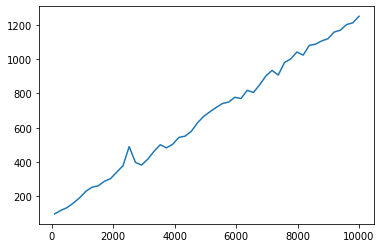

In [13]:
plt.plot(nb_sso_list, time_taken)
plt.show()

In [14]:
time_taken

[98.29573202133179,
 118.86556434631348,
 135.13642573356628,
 161.31443452835083,
 191.55195331573486,
 229.1448109149933,
 253.6656563282013,
 261.79006242752075,
 287.90459418296814,
 303.95447039604187,
 341.4738574028015,
 378.719220161438,
 490.0917513370514,
 398.5029036998749,
 382.6512825489044,
 417.0800881385803,
 463.2008535861969,
 500.87300157546997,
 482.9688882827759,
 503.63116550445557,
 543.575211763382,
 551.0303010940552,
 578.9198009967804,
 628.6987664699554,
 666.3248739242554,
 693.0301377773285,
 717.8999185562134,
 740.6717219352722,
 749.2424492835999,
 777.3175237178802,
 770.1666624546051,
 817.7073864936829,
 805.515896320343,
 849.8269987106323,
 901.2736933231354,
 933.3050651550293,
 906.8821315765381,
 979.6723647117615,
 1000.191897392273,
 1040.9381427764893,
 1022.7825877666473,
 1079.341424703598,
 1086.5163760185242,
 1105.360223531723,
 1118.2614946365356,
 1156.971043586731,
 1167.8912551403046,
 1200.7154440879822,
 1210.7755892276764,
 1249.0

In [15]:
# save time taken 
time_taken = [98.29573202133179,
 118.86556434631348,
 135.13642573356628,
 161.31443452835083,
 191.55195331573486,
 229.1448109149933,
 253.6656563282013,
 261.79006242752075,
 287.90459418296814,
 303.95447039604187,
 341.4738574028015,
 378.719220161438,
 490.0917513370514,
 398.5029036998749,
 382.6512825489044,
 417.0800881385803,
 463.2008535861969,
 500.87300157546997,
 482.9688882827759,
 503.63116550445557,
 543.575211763382,
 551.0303010940552,
 578.9198009967804,
 628.6987664699554,
 666.3248739242554,
 693.0301377773285,
 717.8999185562134,
 740.6717219352722,
 749.2424492835999,
 777.3175237178802,
 770.1666624546051,
 817.7073864936829,
 805.515896320343,
 849.8269987106323,
 901.2736933231354,
 933.3050651550293,
 906.8821315765381,
 979.6723647117615,
 1000.191897392273,
 1040.9381427764893,
 1022.7825877666473,
 1079.341424703598,
 1086.5163760185242,
 1105.360223531723,
 1118.2614946365356,
 1156.971043586731,
 1167.8912551403046,
 1200.7154440879822,
 1210.7755892276764,
 1249.055584192276]

[98.29573202133179,
 118.86556434631348,
 135.13642573356628,
 161.31443452835083,
 191.55195331573486,
 229.1448109149933,
 253.6656563282013,
 261.79006242752075,
 287.90459418296814,
 303.95447039604187,
 341.4738574028015,
 378.719220161438,
 490.0917513370514,
 398.5029036998749,
 382.6512825489044,
 417.0800881385803,
 463.2008535861969,
 500.87300157546997,
 482.9688882827759,
 503.63116550445557,
 543.575211763382,
 551.0303010940552,
 578.9198009967804,
 628.6987664699554,
 666.3248739242554,
 693.0301377773285,
 717.8999185562134,
 740.6717219352722,
 749.2424492835999,
 777.3175237178802,
 770.1666624546051,
 817.7073864936829,
 805.515896320343,
 849.8269987106323,
 901.2736933231354,
 933.3050651550293,
 906.8821315765381,
 979.6723647117615,
 1000.191897392273,
 1040.9381427764893,
 1022.7825877666473,
 1079.341424703598,
 1086.5163760185242,
 1105.360223531723,
 1118.2614946365356,
 1156.971043586731,
 1167.8912551403046,
 1200.7154440879822,
 1210.7755892276764,
 1249.0

## Strong scaling

In [5]:
nb_core = [2, 4, 8, 16, 32, 64, 128]
nb_sso = 5000

In [8]:
compute_orbit(sso_mpc, nb_sso)

begin compute orbital elem on spark
nb sso: 5000
elapsed time: 2252.5763251781464


## results

In [2]:
time_taken_results = {
    2: 5636.6594314575195,
    4: 2252.5763251781464,
    8: 1102.4880459308624,
    16: 622.9926776885986,
    32: 325.71352076530457,
    64: 245.72408199310303,
    128: 325.6921489238739
}

## Complexity Plots

#### Orbfit spark

# save time taken 

In [3]:
def rms(res_lsq):
    return np.sqrt((res_lsq.fun ** 2).mean())


nb_sso_list = np.linspace(100, 10000, dtype=int)

In [4]:
# save time taken 
time_taken = [98.29573202133179,
 118.86556434631348,
 135.13642573356628,
 161.31443452835083,
 191.55195331573486,
 229.1448109149933,
 253.6656563282013,
 261.79006242752075,
 287.90459418296814,
 303.95447039604187,
 341.4738574028015,
 378.719220161438,
 490.0917513370514,
 398.5029036998749,
 382.6512825489044,
 417.0800881385803,
 463.2008535861969,
 500.87300157546997,
 482.9688882827759,
 503.63116550445557,
 543.575211763382,
 551.0303010940552,
 578.9198009967804,
 628.6987664699554,
 666.3248739242554,
 693.0301377773285,
 717.8999185562134,
 740.6717219352722,
 749.2424492835999,
 777.3175237178802,
 770.1666624546051,
 817.7073864936829,
 805.515896320343,
 849.8269987106323,
 901.2736933231354,
 933.3050651550293,
 906.8821315765381,
 979.6723647117615,
 1000.191897392273,
 1040.9381427764893,
 1022.7825877666473,
 1079.341424703598,
 1086.5163760185242,
 1105.360223531723,
 1118.2614946365356,
 1156.971043586731,
 1167.8912551403046,
 1200.7154440879822,
 1210.7755892276764,
 1249.055584192276]

In [5]:
minute_time = np.array(time_taken) / 60

In [80]:
## fit linear
from scipy.optimize import least_squares

def f(x, t):
    return x[0] * t + x[1]

def f_log(x, t):
    return x[0] * (np.log10(t) * t) + x[1]

def f_square(x, t):
    return x[0] * t**2 + x[1]

def f_cube(x, t):
    return x[0] * t**3 + x[1]

def loss(x, t, y):
    return f(x, t) - y

def loss_log(x, t, y):
    return f_log(x, t) - y

def loss_square(x, t, y):
    return f_square(x, t) - y

def loss_cube(x, t, y):
    return f_cube(x, t) - y

x_0 = np.array([1.0, 1.0])

res_lin = least_squares(loss, x_0, args=(nb_sso_list, minute_time))
res_log = least_squares(loss_log, x_0, args=(nb_sso_list, minute_time))

spark configuration:
* 16 total cores
* 2 cores/executors
* 2GB of RAM / executors

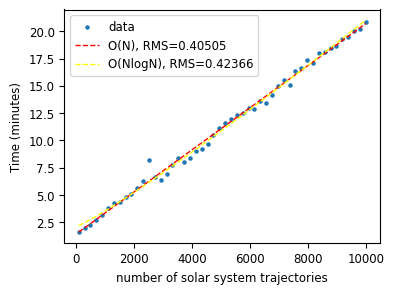

In [81]:
plt.rcParams.update({'font.size': 8.5})
fig = plt.figure(figsize=(4, 3))

# fig.suptitle("Orbfit complexity, weak scaling")
plt.scatter(nb_sso_list, minute_time, label="data", s=5)

plt.plot(
    nb_sso_list, 
    f(res_lin.x, nb_sso_list), 
    label="O(N), RMS={:.5f}".format(rms(res_lin)), 
    linestyle="--", 
    color="red", linewidth=1
)
plt.plot(
    nb_sso_list, 
    f_log(res_log.x, nb_sso_list), 
    label="O(NlogN), RMS={:.5f}".format(rms(res_log)), 
    linestyle="--", 
    color="yellow", linewidth=1
)

plt.xlabel("number of solar system trajectories")
plt.ylabel("Time (minutes)")
plt.legend()
plt.tight_layout()
plt.savefig("orbfit_comp_weak.pgf")
plt.show()

In [82]:
time_taken_results = {
    2: 5636.6594314575195,
    4: 2252.5763251781464,
    8: 1102.4880459308624,
    16: 622.9926776885986,
    32: 325.71352076530457,
    64: 245.72408199310303,
    128: 325.6921489238739
}

In [83]:
result_strong  = np.array([[core, t_time] for core, t_time in time_taken_results.items()])

nb alerts: 5000

In [84]:
def f(x, t):
    return x / t


def loss(x, t, y):
    return f(x, t) - y

x_0 = np.array([1.0])

res_lsq = least_squares(loss, x_0, args=(result_strong[:, 0], result_strong[:, 1] / 60))

In [85]:
res_lsq.x

array([178.75012511])

In [86]:
f(res_lsq.x, result_strong[:, 0])

array([89.37506255, 44.68753128, 22.34376564, 11.17188282,  5.58594141,
        2.7929707 ,  1.39648535])

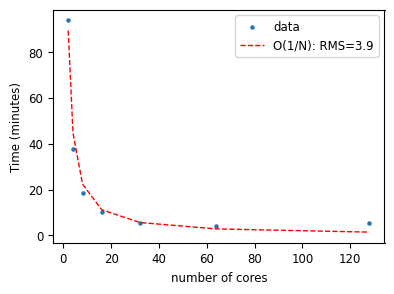

In [87]:
plt.rcParams.update({'font.size': 8.5})

fig = plt.figure(figsize=(4, 3))

# fig.suptitle("Orbfit complexity, strong scaling")
plt.scatter(result_strong[:, 0], result_strong[:, 1] / 60, label="data", s=5)
plt.plot(
    result_strong[:, 0], 
    f(res_lsq.x, result_strong[:, 0]), 
    label="O(1/N): RMS={:.1f}".format(rms(res_lsq)), 
    linewidth=1,
    linestyle="--", color="red"
)

plt.xlabel("number of cores")
plt.ylabel("Time (minutes)")
plt.legend()
plt.tight_layout()
plt.savefig("orbfit_comp_strong.pgf")
plt.show()

## fink-fat complexity

In [94]:
percent_exp = np.array([20, 40, 60, 80, 100])

data_path = [f"../fink_fat_experiments/complexity_data/time_{x}_results.parquet" for x in percent_exp]
data_path

['../fink_fat_experiments/complexity_data/time_20_results.parquet',
 '../fink_fat_experiments/complexity_data/time_40_results.parquet',
 '../fink_fat_experiments/complexity_data/time_60_results.parquet',
 '../fink_fat_experiments/complexity_data/time_80_results.parquet',
 '../fink_fat_experiments/complexity_data/time_100_results.parquet']

In [95]:
## input dataset

import requests
import pandas as pd
import io

# get stats for all the year 2021
r = requests.post(
  'https://fink-portal.org/api/v1/statistics',
  json={
    'date': '2021',
    'output-format': 'json'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))
stats_data = pdf[(pdf["key:key"] >= "ztf_20210101") & (pdf["key:key"] <= "ztf_20210116")]

In [96]:
stats_data["class:Solar System MPC"].mean() * 0.2

6204.0375

In [97]:
alerts_rate_data = []

for exp in percent_exp:
    nb_alerts = stats_data["class:Solar System MPC"].sum() * (exp / 100)
    alerts_rate = nb_alerts / len(stats_data)
    alerts_rate_data.append(alerts_rate)
    print(f"{alerts_rate} alerts/day")

6204.0375 alerts/day
12408.075 alerts/day
18612.1125 alerts/day
24816.15 alerts/day
31020.1875 alerts/day


#### compute time for 100 % experience

In [98]:
assoc_time_100 = [
    11.667613983154297,
    21.94364857673645 + 0.33076047897338867 + 0.34174561500549316 + 0.4055042266845703 + 0.862703800201416,
    9.108948469161987 + 0.6455700397491455 + 0.9703571796417236 + 0.9003002643585205 + 1.7832131385803223,
    37.84625267982483 + 2.7326881885528564 + 2.301823854446411 + 1.5356886386871338 + 1.1848113536834717,
    35.15529489517212 + 5.748280048370361 + 7.233269453048706 + 1.2046258449554443 + 1.9718427658081055,
    39.35244536399841 + 12.719834804534912 + 12.372071743011475 + 0.9935741424560547 + 0.909109354019165,
    63.79172873497009 + 17.224143743515015 + 10.361931085586548 + 1.4177331924438477 + 1.0574407577514648,
    44.76765751838684 + 22.67185616493225 + 21.430789709091187 + 1.008538007736206 + 1.1352391242980957,
    80.07587218284607 + 29.77538275718689 + 23.096110343933105 + 0.8148300647735596 + 0.6984593868255615,
    30.797842025756836 + 19.66373300552368 + 31.03143620491028 + 0.589533805847168 + 0.43274950981140137,
    34.40571141242981 + 26.992212533950806 + 33.81742024421692 + 0.31553101539611816 + 0.34887123107910156,
    46.251025438308716 + 27.011802911758423+ 21.7482590675354 + 0.3081345558166504 + 0.38375353813171387,
    44.69142270088196 + 35.87539267539978 + 37.06379723548889 + 0.27239370346069336 + 0.24348759651184082,
    58.63583469390869 + 39.74068903923035 + 26.018784761428833 + 0.4976661205291748 + 0.44391679763793945,
    3.677855968475342 + 11.12377142906189 + 21.98065686225891 + 0.14791393280029297 + 0.1566307544708252,
    61.784518003463745 + 43.87820625305176 + 32.49102997779846 + 0.3582875728607178 + 0.28596997261047363
]
sum_assoc_100_exp = np.array(assoc_time_100).sum()

In [99]:
orbit_time_100 = [
    30.56755304336548,
    32.2139527797699,
    71.63085770606995,
    71.44734406471252,
    83.87157487869263,
    132.16986227035522,
    273.3602316379547,
    270.6445767879486,
    599.5720891952515,
    453.2025315761566,
    689.6142508983612,
    775.2573454380035,
    901.3925065994263,
    1094.0364499092102,
    410.35379910469055,
    1588.9078919887543
]
sum_orbit_100_exp = np.array(orbit_time_100).sum()

In [100]:
mean_assoc, std_assoc = [], []
mean_orb, std_orb = [], []
mean_ff, std_ff = [], []

In [101]:
for p in data_path:
    pdf = pd.read_parquet(p)
    print(pdf)
    print()
    print()
    res = pdf[pdf["assoc_time"] > 0]
    mean_assoc.append(res["assoc_time"].sum())
    # std_assoc.append(res["assoc_time"].std())

    mean_orb.append(res["orbit_time"].sum())
    # std_orb.append(res["orbit_time"].std())

    mean_ff.append(res["assoc_time"].sum() + res["orbit_time"].sum())
    # std_ff.append(np.sqrt(res["assoc_time"].std()**2 + res["orbit_time"].std()**2))

     assoc_time  orbit_time        date
0      3.560993    2.731735  2021-01-01
1      4.121243    2.944577  2021-01-02
2      4.618732    2.561774  2021-01-03
3      6.419934    2.570922  2021-01-04
4      8.224800    2.122533  2021-01-05
5      8.650231   38.360929  2021-01-06
6     11.679972   32.290651  2021-01-07
7      9.958385   37.520520  2021-01-08
8     14.028228   54.498358  2021-01-09
9     14.682924   46.761980  2021-01-10
10   181.787237    3.219662  2021-01-11
11 -6778.766373   80.172202  2021-01-12
12    17.307588   83.314006  2021-01-13
13    19.612458   83.765946  2021-01-14
14    11.249896   80.815321  2021-01-15
15    20.435205  102.872510  2021-01-16


      assoc_time  orbit_time        date
0       5.052061    2.914262  2021-01-01
1       6.062996    2.682486  2021-01-02
2       6.747444    2.874137  2021-01-03
3      11.736605   30.482745  2021-01-04
4      13.744864   38.824314  2021-01-05
5      18.022933   56.304881  2021-01-06
6      21.751052   84.039586  2

In [102]:
mean_assoc[-1] = sum_assoc_100_exp
mean_orb[-1] = sum_orbit_100_exp
mean_ff[-1] = sum_assoc_100_exp + sum_orbit_100_exp

In [103]:
mean_assoc, mean_orb, mean_ff

([336.3378264904022,
  378.34734559059143,
  689.5068144798279,
  920.7480022907257,
  1225.015934228897],
 [576.3514235019684,
  1041.8014657497406,
  3176.932500600815,
  5079.547572135925,
  7478.242817878723],
 [912.6892499923706,
  1420.148811340332,
  3866.4393150806427,
  6000.295574426651,
  8703.25875210762])

In [104]:
percent_exp, time_assoc, x_0

(array([ 20,  40,  60,  80, 100]),
 array([ 5.60563044,  6.30578909, 11.49178024, 15.34580004, 20.41693224]),
 array([1., 1.]))

In [105]:
time_assoc = np.array(mean_assoc) / 60
# std_time_orb = np.array(std_orb) / 60

res_log = least_squares(loss_log, x_0, args=(percent_exp, time_assoc))
res_lin = least_squares(loss, x_0, args=(percent_exp, time_assoc))
res_square = least_squares(loss_square, x_0, args=(percent_exp, time_assoc))
res_cube = least_squares(loss_cube, x_0, args=(percent_exp, time_assoc))

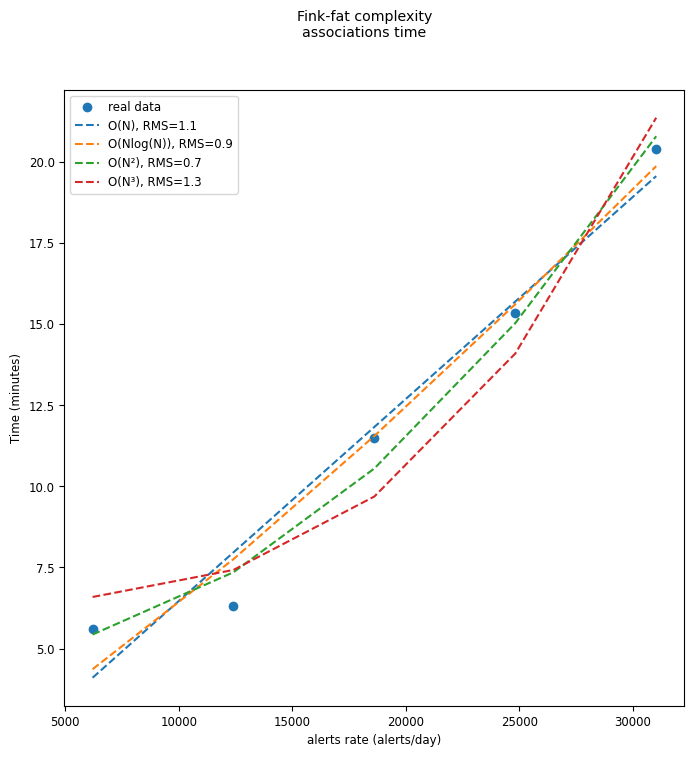

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))

fig.suptitle("Fink-fat complexity\nassociations time")

plt.scatter(alerts_rate_data, time_assoc, label="real data")
# for i, rate in enumerate(alerts_rate_data):
#     ax.annotate(f"{int(rate)} alerts/day", (percent_exp[i]-3, time_assoc[i]+2))

# plt.errorbar(percent_exp, mean_assoc, yerr=std_assoc, linestyle="None")


plt.plot(alerts_rate_data, f(res_lin.x, percent_exp), label="O(N), RMS={:.1f}".format(rms(res_lin)), linestyle="--")
plt.plot(alerts_rate_data, f_log(res_log.x, percent_exp), label="O(Nlog(N)), RMS={:.1f}".format(rms(res_log)), linestyle="--")
plt.plot(alerts_rate_data, f_square(res_square.x, percent_exp), label="O(N²), RMS={:.1f}".format(rms(res_square)), linestyle="--")
plt.plot(alerts_rate_data, f_cube(res_cube.x, percent_exp), label="O(N³), RMS={:.1f}".format(rms(res_cube)), linestyle="--")


plt.xlabel("alerts rate (alerts/day)")
plt.ylabel("Time (minutes)")
plt.legend()
plt.show()

In [107]:
time_orb = np.array(mean_orb) / 60
std_time_orb = np.array(std_orb) / 60

def f(x, t):
    return x[0] * t + x[1]


def loss(x, t, y):
    return f(x, t) - y

x_0 = np.array([1.0, 1.0])

res_lsq = least_squares(loss_log, x_0, args=(percent_exp, time_orb))


res_log = least_squares(loss_log, x_0, args=(percent_exp, time_orb))
res_lin = least_squares(loss, x_0, args=(percent_exp, time_orb))
res_square = least_squares(loss_square, x_0, args=(percent_exp, time_orb))
res_cube = least_squares(loss_cube, x_0, args=(percent_exp, time_orb))

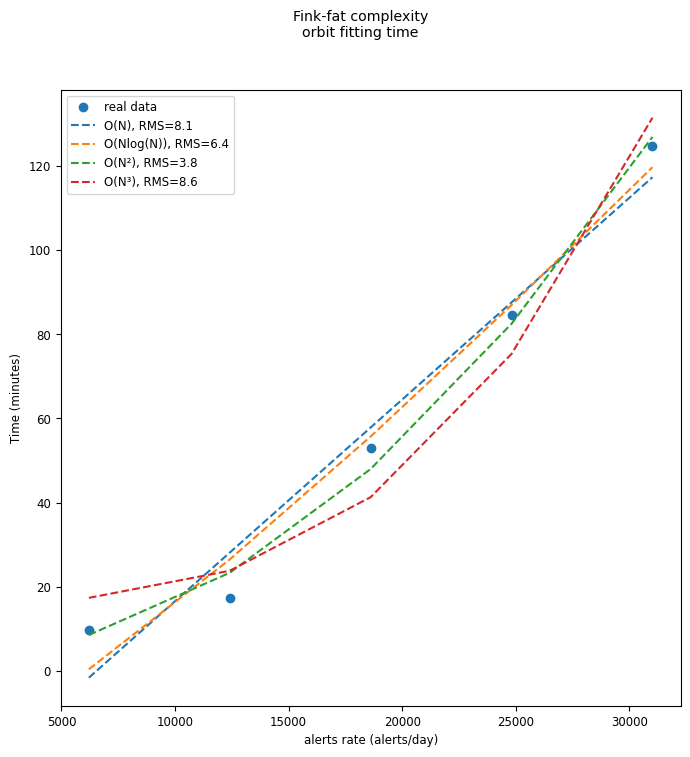

In [108]:
fig, ax = plt.subplots(figsize=(8, 8))

fig.suptitle("Fink-fat complexity\norbit fitting time")

ax.scatter(alerts_rate_data, time_orb, label="real data")
# for i, rate in enumerate(alerts_rate_data):
#     ax.annotate(f"{int(rate)} alerts/day", (percent_exp[i]-1, time_orb[i] + 0.3))

# ax.errorbar(percent_exp, time_orb, yerr=std_time_orb, linestyle="None")


plt.plot(alerts_rate_data, f(res_lin.x, percent_exp), label="O(N), RMS={:.1f}".format(rms(res_lin)), linestyle="--")
plt.plot(alerts_rate_data, f_log(res_log.x, percent_exp), label="O(Nlog(N)), RMS={:.1f}".format(rms(res_log)), linestyle="--")
plt.plot(alerts_rate_data, f_square(res_square.x, percent_exp), label="O(N²), RMS={:.1f}".format(rms(res_square)), linestyle="--")
plt.plot(alerts_rate_data, f_cube(res_cube.x, percent_exp), label="O(N³), RMS={:.1f}".format(rms(res_cube)), linestyle="--")


ax.set_xlabel("alerts rate (alerts/day)")
ax.set_ylabel("Time (minutes)")
ax.legend()
plt.show()

In [109]:
time_ff = np.array(mean_ff) / 60
std_time_ff = np.array(std_ff) / 60

def f(x, t):
    return x[0] * t + x[1]


def loss(x, t, y):
    return f(x, t) - y

x_0 = np.array([1.0, 1.0])

res_lsq = least_squares(loss, x_0, args=(percent_exp, time_ff))

res_log = least_squares(loss_log, x_0, args=(percent_exp, time_ff))
res_lin = least_squares(loss, x_0, args=(percent_exp, time_ff))
res_square = least_squares(loss_square, x_0, args=(percent_exp, time_ff))
res_cube = least_squares(loss_cube, x_0, args=(percent_exp, time_ff))

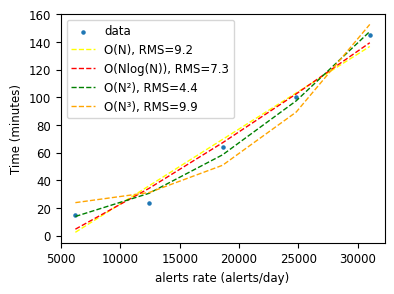

In [110]:
plt.rcParams.update({'font.size': 8.5})

fig, ax = plt.subplots(figsize=(4, 3))

# fig.suptitle("Fink-fat complexity\n(associations + orbit fitting) time")

ax.scatter(alerts_rate_data, time_ff, label="data", s=5)
# for i, rate in enumerate(alerts_rate_data):
#     ax.annotate(f"{int(rate)} alerts/day", (percent_exp[i]-1, time_ff[i] + 0.3))


# ax.errorbar(percent_exp, time_ff, yerr=std_time_ff, linestyle="None")


plt.plot(
    alerts_rate_data, 
    f(res_lin.x, percent_exp), 
    label="O(N), RMS={:.1f}".format(rms(res_lin)), 
    linewidth=1,
    linestyle="--", color="yellow"
)
plt.plot(
    alerts_rate_data, 
    f_log(res_log.x, percent_exp), 
    label="O(Nlog(N)), RMS={:.1f}".format(rms(res_log)), 
    linewidth=1,
    linestyle="--", color="red"
)
plt.plot(
    alerts_rate_data, 
    f_square(res_square.x, percent_exp), 
    label="O(N²), RMS={:.1f}".format(rms(res_square)), 
    linewidth=1,
    linestyle="--", color="green"
)
plt.plot(
    alerts_rate_data, 
    f_cube(res_cube.x, percent_exp), 
    label="O(N³), RMS={:.1f}".format(rms(res_cube)), 
    linewidth=1,
    linestyle="--", color="orange"
)


ax.set_xlabel("alerts rate (alerts/day)")
ax.set_ylabel("Time (minutes)")
ax.legend()
plt.tight_layout()
plt.savefig("fink_fat_pipeline_comp.pgf")
plt.show()